# 06_01_neu: CNN Basics (CPU-friendly)

Ziele:
- Mini-CNN auf CIFAR-10 in wenigen Minuten trainieren
- Feature-Maps sichtbar machen
- Manuelle Faltung vs. tf.nn.conv2d prüfen

## Einführung
Schneller Einstieg in CNN-Grundideen mit minimalem Rechenaufwand: kleines CIFAR-10-Subset, schlankes Modell, Feature-Maps sichtbar machen und eine manuelle Faltung gegen `tf.nn.conv2d` prüfen.

**Lernziele**
- Zusammenspiel von Convolution, Pooling und Dense-Schichten in einem Mini-CNN verstehen
- CIFAR-10 laden, normalisieren, in Klassen visualisieren und ein kleines Modell trainieren (CPU-tauglich)
- Feature-Maps der ersten Conv-Schicht interpretieren
- Manuelle Kernel-Faltung mit TensorFlow vergleichen, um das Rechenprinzip zu verankern
- Praktische Stellschrauben kennen: Samples/Epochen reduzieren, um Laufzeit zu senken

In [1]:
# Setup: imports, seeds, plotting style
import os, random, math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

print(tf.__version__)
print("GPU available:", bool(tf.config.list_physical_devices('GPU')))


2.19.1
GPU available: False


In [2]:
# Load CIFAR-10 (subsampled for speed)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Subsample to stay CPU-friendly
train_keep = 10000
test_keep = 2000
x_train, y_train = x_train[:train_keep], y_train[:train_keep]
x_test, y_test = x_test[:test_keep], y_test[:test_keep]

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
print("Train:", x_train.shape, "Test:", x_test.shape)

Train: (10000, 32, 32, 3) Test: (2000, 32, 32, 3)


/var/folders/qz/yzbl_3nj31sfz8p5s1wydw4c0000gn/T/ipykernel_22967/3553749317.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(class_names[int(label)])


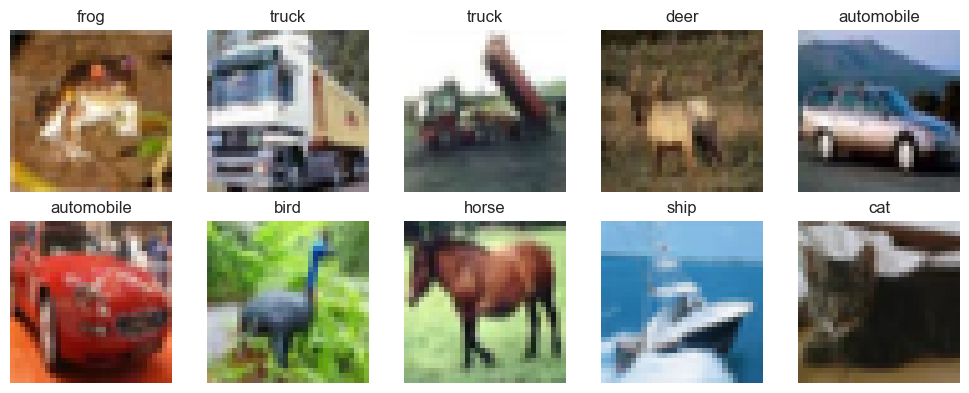

In [3]:
# Quick look at samples
fig, axes = plt.subplots(2, 5, figsize=(10,4))
for ax, img, label in zip(axes.flat, x_train[:10], y_train[:10]):
    ax.imshow(img)
    ax.set_title(class_names[int(label)])
    ax.axis("off")
plt.tight_layout()
plt.show()

In [4]:
# Define a small CNN (keeps params low)
model = keras.Sequential([
    layers.Input(shape=(32,32,3)),
    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation="relu", padding="same"),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax"),
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,154 (399.04 KB)

 Trainable params: 102,154 (399.04 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train briefly (CPU-friendly)
history = model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=2,
    batch_size=128,
    verbose=2,
)


Epoch 1/2


71/71 - 3s - 37ms/step - accuracy: 0.1769 - loss: 2.1744 - val_accuracy: 0.2010 - val_loss: 2.0571


Epoch 2/2


71/71 - 2s - 28ms/step - accuracy: 0.2696 - loss: 1.9020 - val_accuracy: 0.3050 - val_loss: 1.7881


In [6]:
# Evaluate and simple report
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {acc:.3f}")

# Quick classification report on a small slice to keep it fast
pred_probs = model.predict(x_test[:500], verbose=0)
preds = np.argmax(pred_probs, axis=1)
print(classification_report(y_test[:500], preds, target_names=class_names, zero_division=0))

Test accuracy: 0.305
              precision    recall  f1-score   support

    airplane       0.37      0.18      0.24        57
  automobile       0.29      0.59      0.38        41
        bird       0.25      0.31      0.28        51
         cat       0.18      0.08      0.11        49
        deer       0.19      0.17      0.18        40
         dog       0.00      0.00      0.00        48
        frog       0.50      0.31      0.39        54
       horse       0.20      0.66      0.31        47
        ship       0.39      0.53      0.45        57
       truck       0.60      0.05      0.10        56

    accuracy                           0.28       500
   macro avg       0.30      0.29      0.24       500
weighted avg       0.31      0.28      0.25       500



/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


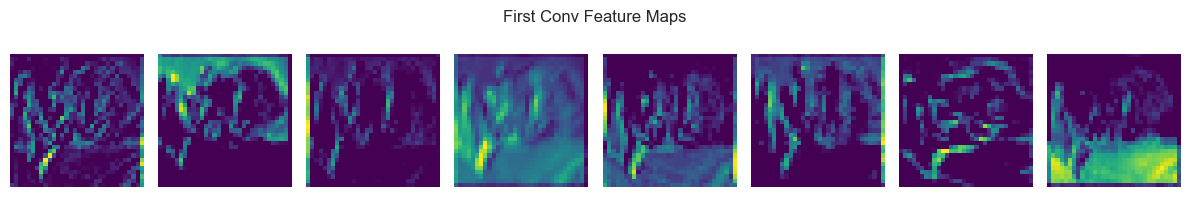

In [7]:
# Visualize feature maps of first conv layer
first_conv = keras.Model(inputs=model.inputs, outputs=model.layers[0].output)
sample = x_test[:1]
feature_maps = first_conv(sample)

n_maps = min(feature_maps.shape[-1], 8)
fig, axes = plt.subplots(1, n_maps, figsize=(12,2))
for i in range(n_maps):
    axes[i].imshow(feature_maps[0, :, :, i], cmap="viridis")
    axes[i].axis("off")
plt.suptitle("First Conv Feature Maps")
plt.tight_layout()
plt.show()

In [8]:
# Manual conv vs tf.nn.conv2d sanity check
img = x_test[0, :, :, 0]  # one channel
kernel = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], dtype=np.float32)

# numpy correlate-style conv (valid)
from scipy.signal import convolve2d
np_out = convolve2d(img, kernel, mode="valid")

# tf conv (needs 4D input and flipped kernel for cross-correlation)
tf_img = tf.convert_to_tensor(img[None, :, :, None])
tf_kernel = tf.convert_to_tensor(kernel[:, :, None, None])
tf_out = tf.nn.conv2d(tf_img, tf_kernel, strides=1, padding="VALID")

diff = np.abs(np_out - tf_out.numpy()[0, :, :, 0]).max()
print("Max diff (should be tiny):", diff)


Max diff (should be tiny): 4.054902


## Tipps
- Falls langsam: `train_keep=5000`, `test_keep=1000`, `epochs=1`.
- Für GPU einfach Epochenzahl erhöhen.
- Feature-Maps helfen, Kernel-Wirkung zu verstehen.